# Исследование продаж компьютерных игр интернет-магазина «Стримчик»

Нам предоставлены данные из файла `games.csv`, которые были собраны из открытых источников о продажах игр, оценках пользователей и экспертов, жанрах, платформах и возрастном рейтинге игр по системе *ESRB*. В таблице имеются данные за 2016 год. Проект построен таким образом, что мы находимся в декабре 2016 года и пытаемся прогнозировать продажи за 2017 год.

**Цель проекта** - на основе полученных данных выявить определяющие успешность игры закономерности, чтобы спланировать рекламную кампанию.

**Ход исследования**

Нам предстоит ознакомиться с данными, провести обзор и их предобработку. Выявим проблемы в данных и опишем возможные причины их появления:

* возможные ошибки в данных (неверный тип данных, некорректные названия столбцов, пропуски);
* полные, явные и неявные дубликаты.

Произведем исследовательский анализ, визуализируем некоторые параметры, определим выбросы и аномалии. Составим портрет пользователей каждого региона. Выполним статистический анализ с формулировкой гипотез о данных и сделаем общий вывод.

# Оглавление

**[1. Обзор данных](#view)**

**[2. Предобработка данных](#preprocessing)**

&emsp; [2.1. Обработка типов данных и пропусков](#dtype_omissions)

&emsp; [2.2. Обработка дубликатов](#duplicates)

&emsp; [2.3. Создание новых столбцов](#new_col)

**[3. Исследовательский анализ](#research)**

**[4. Портреты пользователей](#users)**

**[5. Проверка гипотез](#hypotheses)**

&emsp; [5.1 Гипотеза о равенстве средних пользовательских оценок для PC и Xbox One](#user_score)

&emsp; [5.2 Гипотеза о неравенстве средних пользовательских оценок для жанров *sport* и *action*](#user_genre)

**[6. Выводы](#conclutions)**

<a id='view'></a>
## Обзор данных

Ознакомимся с данными: прочитаем файл, выведем общую информацию по датасету и 5 первых ее строк, дадим комментарии по полноте, объему и типу данных:

In [1]:
# Импорт необходимых библиотек и модулей
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
from scipy import stats as st
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
# Прочитаем CSV файл
df = pd.read_csv('/datasets/games.csv')

# Выведем основную информацию о датафрейме
df.info()

df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


Предствлено 11 столбцов, в которых представлены следующие данные:
1. `Name` - название игры;
2. `Platform` - платформа, для которой игра выпущена;
3. `Year_of_Release` - год выпуска игры;
4. `Genre` - жанр;
5. `NA_sales` - количество проданных копий в Северной Америке (млн. копий);
6. `EU_sales` - количество проданных копий в Европе (млн. копий);
7. `JP_sales` - количество проданных копий в Японии (млн. копий);
8. `Others_sales` - количество проданных копий в остальном мире (млн. копий);
9. `Critic_Score` - оценка критиков (максимум 100);
10. `User_Score` - оценка игроков (максимум 10);
11. `Rating` - возрастная категория.

Все наименования столбцов написаны в непривычном стиле (в дальнейшем изменим на змеиный регистр). Представленные данные имеют много пропусков, в частности в столбцах `Name`, `Year_of_Release`, `Genre`, `Critic_Score`, `User_Score`и `Rating`. В некоторых столбцах пропущено всего пару строк, когда как в других отсутствует около половины данных. Общий объем - 16715 строк, данное количество строк можем обрабатывать с помощью *pandas* без ограничений, создавать выборку по имеющимся данным не требуется. В некоторых столбцах выбран неверный тип данных, что необходимо будет исправить.

<a id='preprocessing'></a>
## Предобработка данных

<a id='dtype_omissions'></a>
### Обработка типов данных и пропусков

Первоначально следует изменить наименования столбцов на более привычные с использованием змеиного регистра, чтобы не привыкать к новым наименованиям посреди повествования. Сразу выведем типы данных в получившейся таблице:

In [3]:
# Изменим названия столбцов

df.columns = df.columns.str.lower()
# Выведем типы данных

df.dtypes

name                object
platform            object
year_of_release    float64
genre               object
na_sales           float64
eu_sales           float64
jp_sales           float64
other_sales        float64
critic_score       float64
user_score          object
rating              object
dtype: object

Необходимо изменить тип данных следующий столбцов:
* `year_of_release` с *float64* на *int64*
* `critic_score` с *float64* на *int64*
* `user_score` с *object* на *float64*

Однако во всех трех столбцах присутствуют пропуски, поэтому изменить тип данных с *float64* не получится. Можем попробовать пока что изменить тип данных в столбце `user_score` с *object* на *float64*. Выведем на экран первые 10 уникальных значений данного столбца:

In [4]:
df['user_score'].value_counts().head(10)

tbd    2424
7.8     324
8       290
8.2     282
8.3     254
8.5     253
7.5     251
7.9     249
8.1     244
7.7     240
Name: user_score, dtype: int64

В данном столбце присутсвует аббревиатура `tbd`, которая расшифровывается как `To be determined`. Это означает, что значение предстоит определить в будущем. Такая аббревиатура может быть использована для анонсированных проектов, которые еще не вышли, либо проект был выпущен недавно и данных было собрано недостаточно для выгрузки в открытый доступ. Следует обратиться к коллегам за уточением данной информации, возможно предоставленные данные слегка устарели, сейчас же такие значения можем заменить на `-2` и изменить тип данных на числовой.

In [5]:
# Заменим значения "tbd" на NaN

df['user_score'] = df['user_score'].replace('tbd', -2)

# Изменим тип данных со строкового на числовой

df['user_score'] = pd.to_numeric(df['user_score'], errors='raise')

# Вывдем тип данных для проверки

print('Тип данных столбца "user_score":', df['user_score'].dtypes)

Тип данных столбца "user_score": float64


Пропуски в столбце `year_of_release` могут быть вызваны тем, что игра находится в процессе разработки и точной даты выхода пока нет, соответственно продаж по таким играм еще не было, за исключением возможных предзаказов, также возможно данные были утеряны при выгрузке. Проверим количество таких пропусков, если их количество невелико, то удалим их и изменим тип данных на целочисленный.

In [6]:
# Посчитаем количество пропусков

print(
    'Количество пропусков в столбце "year_of_release":',
    df['year_of_release'].isna().sum()
)

print(
    'Доля пропусков в столбце "year_of_release":',
    df['year_of_release'].isna().sum() / df.shape[0]
)

print()

# Удалим пропуски

df = df.dropna(subset=['year_of_release'])

# Изменим тип данных на "int64"

df['year_of_release'] = df['year_of_release'].astype('int', errors='raise')

# Выведем общую информацию о преобразованном датафрейме

df.info()

Количество пропусков в столбце "year_of_release": 269
Доля пропусков в столбце "year_of_release": 0.01609332934489979

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16446 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16444 non-null  object 
 1   platform         16446 non-null  object 
 2   year_of_release  16446 non-null  int64  
 3   genre            16444 non-null  object 
 4   na_sales         16446 non-null  float64
 5   eu_sales         16446 non-null  float64
 6   jp_sales         16446 non-null  float64
 7   other_sales      16446 non-null  float64
 8   critic_score     7983 non-null   float64
 9   user_score       9839 non-null   float64
 10  rating           9768 non-null   object 
dtypes: float64(6), int64(1), object(4)
memory usage: 1.5+ MB


Доля пропусков составляла всего 1.6%, данные пропуски были удалены.

Имеется по два пропуска в столбцах `name` и `ganre`. Удалим пропуски в одном столбце, возможно данные пропуски пересекаются:

In [7]:
# Удалим пропуски в столбце "name"

df = df.dropna(subset=['name'])

# Выведем общую информацию по датафрейму

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16444 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16444 non-null  object 
 1   platform         16444 non-null  object 
 2   year_of_release  16444 non-null  int64  
 3   genre            16444 non-null  object 
 4   na_sales         16444 non-null  float64
 5   eu_sales         16444 non-null  float64
 6   jp_sales         16444 non-null  float64
 7   other_sales      16444 non-null  float64
 8   critic_score     7983 non-null   float64
 9   user_score       9839 non-null   float64
 10  rating           9768 non-null   object 
dtypes: float64(6), int64(1), object(4)
memory usage: 1.5+ MB


Пропуски действительно пересекающиеся, осталось разобраться с пропусками в столбцах с рейтингом возрастного ограничения и оценками пользователей и критиков.

Напомним, что в столбце `rating` находятся значения рейтинга от организации ESRB, деятельность которой ограничена Канадой, США и Мексикой. Играм, которые не выходили на рынке перечисленных стран, мог быть просто не выставлен рейтинг. Также рейтинг мог не выставляться некоторым инди проектам или проектам с ограниченным финансированием и рекламой. Еще одной причиной может быть, что рейтинг еще не выставлен, то есть рейтинг "RP" ("Rating Pending") - рейтинг ожидается. Таких пропусков много и это наверняка не случайность, удалять их нельзя. Такие пропуски заменим на значение `unknown`.

Пропуски в столбцах `critic_score` и `user_score` могут быть вызваны одними и теми же причинами. Малоизвестные проекты с низкими продажами могут быть проигнорированы как критиками, так и игровым сообществом в целом, что повлечет за собой редкие или отсутствующие оценки. В обоих столбцах заменим пропуски на `-1` и снова выведем общую информацию о датафрейме. Также обновим индексацию в датафрейме после всех преобразований.

In [8]:
# Заменим пропуски в столбцах на соответствующие значения

df['rating'] = df['rating'].fillna('unknown')

df['user_score'] = df['user_score'].fillna(-1)

df['critic_score'] = df['critic_score'].fillna(-1)

# Изменим тип данных в столбце "critic_score" на целочисленный

df['critic_score'] = df['critic_score'].astype('int', errors='raise')

# Обновим индексацию во всем датафрейме

df = df.reset_index(drop=True)

# Выведем общую информацию о датафрейме

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16444 entries, 0 to 16443
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16444 non-null  object 
 1   platform         16444 non-null  object 
 2   year_of_release  16444 non-null  int64  
 3   genre            16444 non-null  object 
 4   na_sales         16444 non-null  float64
 5   eu_sales         16444 non-null  float64
 6   jp_sales         16444 non-null  float64
 7   other_sales      16444 non-null  float64
 8   critic_score     16444 non-null  int64  
 9   user_score       16444 non-null  float64
 10  rating           16444 non-null  object 
dtypes: float64(5), int64(2), object(4)
memory usage: 1.4+ MB


Все пропуски обработаны, типы данных исправлены на нужные.

<a id='duplicates'></a>
### Обработка дубликатов

Необходимо обработать датафрейм от дубликатов. Для начала приведем все столбцы со строковыми типами данных к нижнему регистру. После чего проверим наличие "совместных" дубликатов в столбцах `name`, `platform` и `year_of_release`. Названия игр могут пересекаться, так как одна игра могла выйти на разных платформах, а также игра могла выйти на одной и той же платформе два раза в разный год, как обновленная версия старой или как совершенно новый продукт. Так например игра `need for speed: most wanted` выходила в 2005 году и в 2013 как совершенно разные игры, однако название имели одинаковое.

In [9]:
# Приведем значения столбцов к нижнему регистру

df['name'] = df['name'].str.lower()

df['platform'] = df['platform'].str.lower()

df['genre'] = df['genre'].str.lower()

df['rating'] = df['rating'].str.lower()

# Выведем количество дубликатов

print(
    'Количество дубликатов:',
    df[['name', 'platform', 'year_of_release']].duplicated().sum()
)

# Выведем количесвто полных дубликатов

print(
    'Количество полных дубликатов:',
    df.duplicated().sum()
)

# Удалим дубликаты

df = df.drop_duplicates(
    subset=['name', 'platform', 'year_of_release'],
    keep='first'
).reset_index(drop=True)

Количество дубликатов: 1
Количество полных дубликатов: 0


Полных дубликатов нет, один дубликат по столбцам отсеян.

<a id='new_col'></a>
### Создание новых столбцов

Необходимо создать доволнительный столбец со значениями продаж в мире. Выведем первые 5 строк итогового датафрейма на экран:

In [10]:
# Создадим столбец "world_sales"

df['world_sales'] = df['na_sales'] + df['eu_sales'] + df['jp_sales'] + df['other_sales']

df.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,world_sales
0,wii sports,wii,2006,sports,41.36,28.96,3.77,8.45,76,8.0,e,82.54
1,super mario bros.,nes,1985,platform,29.08,3.58,6.81,0.77,-1,-1.0,unknown,40.24
2,mario kart wii,wii,2008,racing,15.68,12.76,3.79,3.29,82,8.3,e,35.52
3,wii sports resort,wii,2009,sports,15.61,10.93,3.28,2.95,80,8.0,e,32.77
4,pokemon red/pokemon blue,gb,1996,role-playing,11.27,8.89,10.22,1.00,-1,-1.0,unknown,31.38


Данные полностью подготовлены для проведения дальнейшего анализа: переименованы названия столбцов, обработаны пропуски, проведен поиск дубликатов и создан дополнительный столбец с общими продажами игры.

<a id='research'></a>
## Исследовательский анализ

Посмотрим сколько игр выпускалось в разные года:

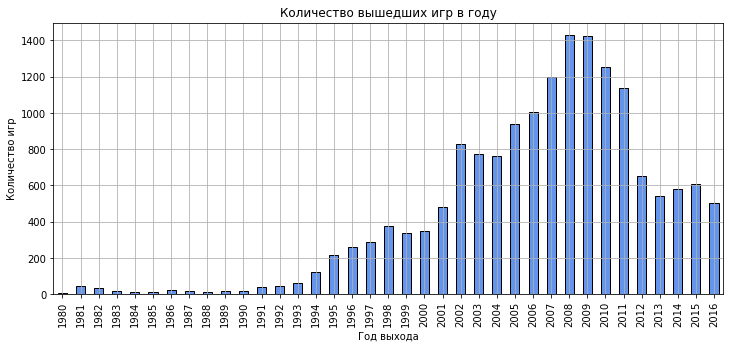

In [11]:
df.pivot_table(index='year_of_release', values='name', aggfunc='count').plot(
    kind='bar',
    edgecolor='black',
    color='cornflowerblue',
    figsize=(12, 5),
    grid=True,
    legend=False
)
plt.title('Количество вышедших игр в году')
plt.xlabel('Год выхода')
plt.ylabel('Количество игр')
plt.show()

Можем заметить, что до 1993 года выходило несравнимо меньше игр, чем во все последующие года. Можем считать, что данные до 1993 года не важны.

Выведем на экран первые 10 строк сводной таблицы и столбчатую диаграмму с продажами по каждой платформе:

,na_sales,eu_sales,jp_sales,other_sales,world_sales
platform,,,,,
ps2,572.92,332.63,137.54,190.47,1233.56
x360,595.74,268.32,12.30,84.88,961.24
ps3,390.13,327.20,79.41,134.59,931.33
wii,486.87,258.32,68.28,77.71,891.18
ds,380.31,188.41,175.02,59.04,802.78
ps,334.72,212.39,139.78,40.69,727.58
ps4,108.74,141.09,15.96,48.35,314.14
gba,184.12,74.59,46.56,7.61,312.88
psp,107.27,65.62,75.88,40.76,289.53


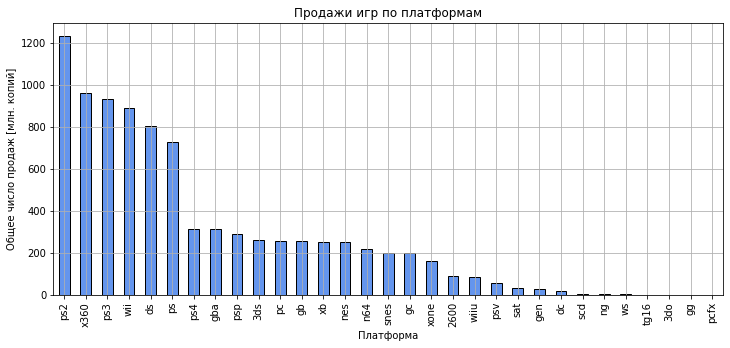

In [12]:
# Создадим сводную таблицу с названиями платформ в качестве индексов

df_platform = df.groupby('platform').agg({'na_sales' : 'sum',
                            'eu_sales' : 'sum',
                            'jp_sales' : 'sum',
                            'other_sales' : 'sum',
                            'world_sales' : 'sum'
                                         }
                                        ).sort_values(
    by='world_sales', ascending=False
)

# Выведем на экран первые 10 строк сводной таблицы

display(df_platform.head(10))

# Построим столбчатую диаграмму с общими продажами

df_platform.plot(
    kind='bar',
    y='world_sales',
    edgecolor='black',
    color='cornflowerblue',
    figsize=(12, 5),
    grid=True,
    legend=False
)
plt.title('Продажи игр по платформам')
plt.xlabel('Платформа')
plt.ylabel('Общее число продаж [млн. копий]')
plt.show()

Можем заметить, что платформы с самыми продаваемыми играми на 2016 год были:
* Playstation 2
* Xbox 360
* Playstation 3
* Nintendo Wii
* Nintendo Dual Screen
* Playstation 1

По ним построим график распределения продаж игр по годам после 1993:

world_sales
platform year_of_release             
ds       2004                   17.27
         2005                  130.14
         2006                  119.81
         2007                  146.94
         2008                  145.31
         2009                  119.54
         2010                   85.02
         2011                   26.18
         2012                   11.01
         2013                    1.54

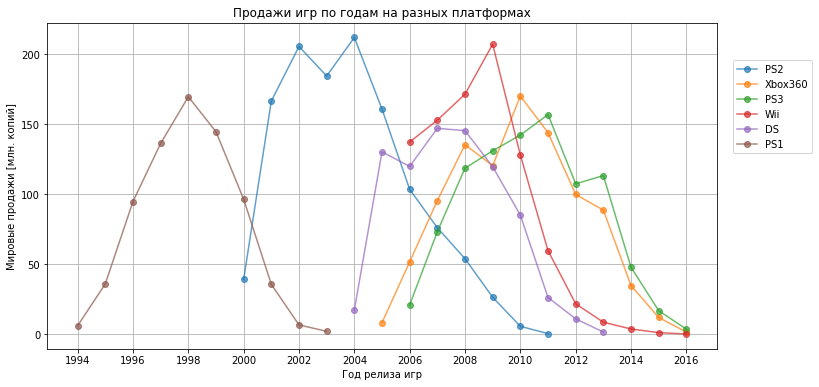

In [13]:
# Запишем названия предпочтительных платформ в переменную (индексы сводной таблицы)

best_platforms = df_platform[0:6].index

# Создадим сводную таблицу с мультииндексом платформа -> год релиза (больше 1992)

df_platform_per_year = df.query('platform in @best_platforms and year_of_release >= 1993').groupby(
    [
        'platform',
        'year_of_release'
    ]
).agg({'world_sales' : 'sum'}).sort_values(by='year_of_release').sort_index(
    level='platform',
    sort_remaining=False # Сортировка с мультииндексом
)

# Изобразим первые 10 строк сводной таблицы

display(df_platform_per_year.head(10))

# Выведем продажи игр на платформах по годам на одном графике

for p in best_platforms:
    df_platform_per_year['world_sales'][p].plot(
        x='year_of_release',
        y='world_sales',
        alpha=0.7,
        marker='o',
        grid=True,
        figsize=(12, 6)
    )
plt.legend(
    bbox_to_anchor = (1.15, 0.9),
    labels=[
        'PS2',
        'Xbox360',
        'PS3',
        'Wii',
        'DS',
        'PS1'
    ]
)
plt.locator_params(
    axis='x',
    nbins=(
        df_platform_per_year.reset_index()['year_of_release'].max() -
        df_platform_per_year.reset_index()['year_of_release'].min() + 1
    ) # Количество делений на оси х
)
plt.title('Продажи игр по годам на разных платформах')
plt.xlabel('Год релиза игр')
plt.ylabel('Мировые продажи [млн. копий]')
plt.show()

На основе графиков можно сделать вывод, что в среднем полное время жизни платформы 9 лет от старта продаж, до прекращения выпуска игр на данной платформе, а наиболее прибыльные периоды жизни платформы в среднем 4-5 лет, в этот период на платформе наблюдаем наибольшее количество продаж и за этот же период от 'начала' жизни платформы достигаются максимальные продажи, после чего они начинают падать. Данный период будем считать *актуальным* при прогнозе продаж.

Создадим новую сводную таблицу, куда включим все платформы с продажами за последние 5 лет и выведем столбчатую диаграмму. Рассмотренные ранее платформы отбросим, так как их продажи на момент 2016 года упали до минимума и они очевидно неперспективны.

,world_sales
platform,
ps4,314.14
3ds,257.81
xone,159.32
pc,97.68
wiiu,82.19
psv,53.81
psp,29.01


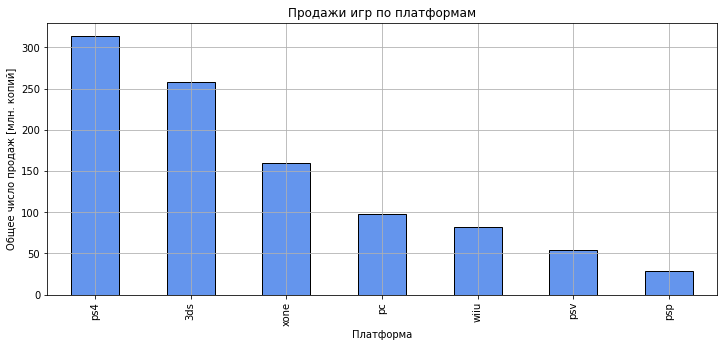

In [15]:
# Создадим даафрейм с платформами, на которых выходили игры последние 5 лет, кроме тех,
# что были рассмотрены ранее

df_platforms_last_five_years = df.query('platform not in @best_platforms and year_of_release >= 2011'
                                       ).groupby('platform'
                                                ).agg({'world_sales' : 'sum'}
                                                     ).sort_values(by='world_sales', ascending=False
                                                                  )

# Выведем на экран первые 10 строк сводной таблицы

display(df_platforms_last_five_years.head(10))

# Построим столбчатую диаграмму с общими продажами

df_platforms_last_five_years.plot(
    kind='bar',
    y='world_sales',
    edgecolor='black',
    color='cornflowerblue',
    figsize=(12, 5),
    grid=True,
    legend=False
)
plt.title('Продажи игр по платформам')
plt.xlabel('Платформа')
plt.ylabel('Общее число продаж [млн. копий]')
plt.show()

world_sales
platform year_of_release             
ds       2004                   17.27
         2005                  130.14
         2006                  119.81
         2007                  146.94
         2008                  145.31
         2009                  119.54
         2010                   85.02
         2011                   26.18
         2012                   11.01
         2013                    1.54

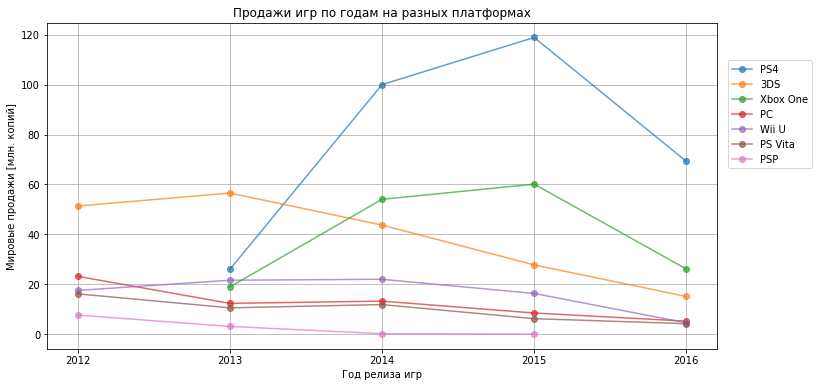

In [16]:
# Запишем названия платформ в переменную (индексы сводной таблицы)

best_platforms_five_years = df_platforms_last_five_years[:].index

# Создадим сводную таблицу с мультииндексом платформа -> год релиза

df_platform_five_years_plot = df.query('platform in @best_platforms_five_years and year_of_release > 2011').groupby(
    [
        'platform',
        'year_of_release'
    ]
).agg({'world_sales' : 'sum'}).sort_values(by='year_of_release').sort_index(
    level='platform',
    sort_remaining=False # Сортировка с мультииндексом
)

# Изобразим первые 10 строк сводной таблицы

display(df_platform_per_year.head(10))

# Выведем продажи игр на платформах по годам на одном графике

for p in best_platforms_five_years:
    df_platform_five_years_plot['world_sales'][p].plot(
        x='year_of_release',
        y='world_sales',
        alpha=0.7,
        marker='o',
        grid=True,
        figsize=(12, 6)
    )
plt.legend(
    bbox_to_anchor = (1.15, 0.9),
    labels=[
        'PS4',
        '3DS',
        'Xbox One',
        'PC',
        'Wii U',
        'PS Vita',
        'PSP'
    ]
)
plt.locator_params(
    axis='x',
    nbins=(
        df_platform_five_years_plot.reset_index()['year_of_release'].max() -
        df_platform_five_years_plot.reset_index()['year_of_release'].min() + 1
    ) # Количество делений на оси х
)
plt.title('Продажи игр по годам на разных платформах')
plt.xlabel('Год релиза игр')
plt.ylabel('Мировые продажи [млн. копий]')
plt.show()

У большинства платформ наблюдается отрицательная динамика продаж, однако следует отметить две:
* PS4
* Xbox One

У этих двух платформ за последний 2016-й год упали продажи, такое случается, когда год не насыщен громкими новинками и готовятся крупные проекты на следующий год, что поспособствует росту продаж. Такие же локальные падения продаж могли замечать и на более старых платформах, когда как оставшиеся показывают стабильное снижение продаж. Выбранные две платформы являются самыми "свежими" на рынке среди популярных. Можем считать их перспективными и потенциально прибыльными.

Изобразим диаграммы размаха для представленных платформ:

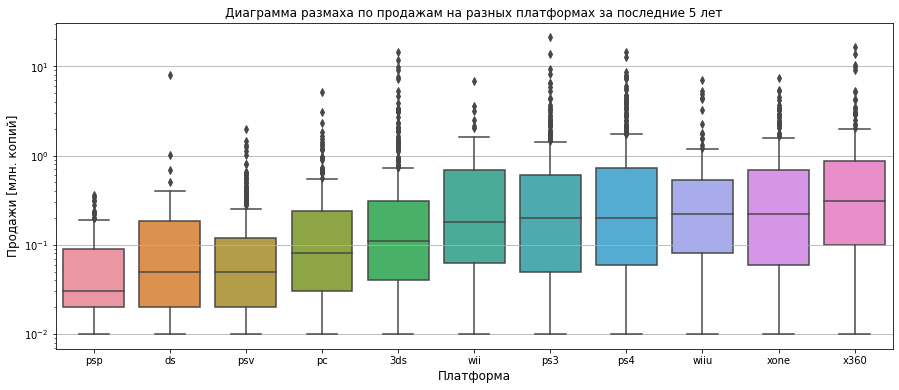

In [17]:
# Отфильтруем данные за последние 5 лет

df_filtered = df.query('year_of_release > 2011')

fig, ax = plt.subplots(figsize=(15, 6))

# Занесем в переменную отсортированные по медианному количеству продаж платформы

order = df_filtered.groupby(by='platform')['world_sales'].median().sort_values().index

# Создадим боксплоты

sns.boxplot(
    data=df_filtered,
    x='platform',
    y='world_sales',
    order=order
)
ax.set_yscale('log')
plt.title('Диаграмма размаха по продажам на разных платформах за последние 5 лет')
plt.xlabel('Платформа', fontsize=12)
plt.ylabel('Продажи [млн. копий]', fontsize=12)
ax.yaxis.grid(True)
plt.show()

Можем заметить, что медианы продаж Xbox One и PS4 находятся примерно наравне с Wii U, когда как общие продажи у первых двух сильно больше. Это может значить что на Xbox и PS4 выходит очень много проектов как плохих, так и хороших с точки зрения продаж, когда как на на Wii U проектов меньше, но большинство из них успешные и продаются хорошо. Можем также причислить платформу Wii U к потенциально прибыльным.

Проверим, как влияют на продажи оценки критиков на платформе PS4. Для этого изобразим диаграмму рассеяния:

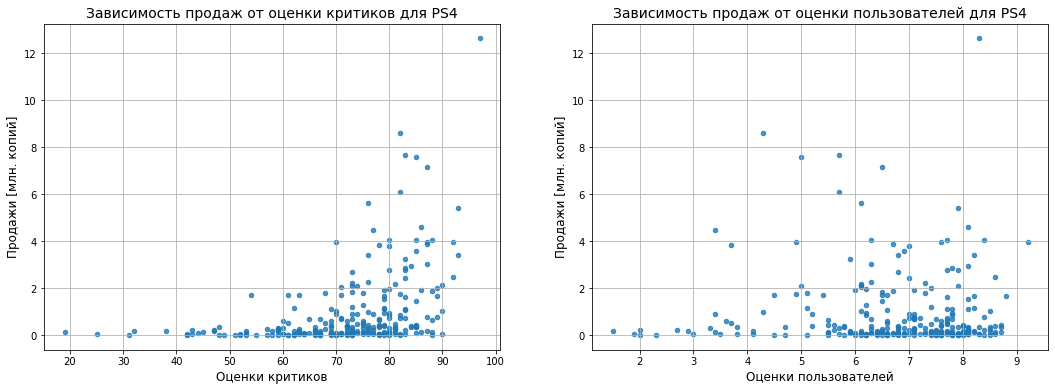

Коэффициент корреляции продаж с оценками критиков для PS4 равен: 0.406567902061781
Коэффициент корреляции продаж с оценками пользователей для PS4 равен: -0.031957110204556376


In [18]:
# Создадим функцию возвращающую график распределения продаж от оценок

def plot_sales_score(data, platform):
    
    # Построение распределения
    
    fig, ax = plt.subplots(1, 2)

    df_filtered.query('platform == @platform and critic_score > 0').plot(
        kind='scatter',
        x='critic_score',
        y='world_sales',
        alpha=0.8,
        ax=ax[0],
        grid=True
    )


    df_filtered.query('platform == @platform and user_score > 0').plot(
        kind='scatter',
        x='user_score',
        y='world_sales',
        alpha=0.8,
        ax=ax[1],
        figsize=(18, 6),
        grid=True
    )
    ax[0].set_title(f'Зависимость продаж от оценки критиков для {platform.upper()}', fontsize=14)
    ax[0].set_xlabel('Оценки критиков', fontsize=12)
    ax[0].set_ylabel('Продажи [млн. копий]', fontsize=12)
    ax[1].set_title(f'Зависимость продаж от оценки пользователей для {platform.upper()}', fontsize=14)
    ax[1].set_xlabel('Оценки пользователей', fontsize=12)
    ax[1].set_ylabel('Продажи [млн. копий]', fontsize=12)
    plt.show()
    
    # Вывод на экран коэффициента корреляции
    
    print(f'Коэффициент корреляции продаж с оценками критиков для {platform.upper()} равен:',
          data.query('platform == @platform and critic_score > 0')['world_sales'].corr(
              data.query('platform == @platform and critic_score > 0')['critic_score']
          )
         )
    print(f'Коэффициент корреляции продаж с оценками пользователей для {platform.upper()} равен:',
          data.query('platform == @platform and user_score > 0')['world_sales'].corr(
              data.query('platform == @platform and user_score > 0')['user_score']
          )
         )

# Вызовем функцию построения распределения
    
plot_sales_score(df_filtered, 'ps4')

По графику заметно, что оценки критиков несильно влияют на продажи. Игры, оцененные до 60 баллов покупаются одинаково плохо. Небольшая зависимость видна после отметки в 60 баллов, но основная доля продаж изменяется несильно, о чем и говорит небольшое значение коэффициента корреляции. Оценки пользователей от продаж имеют корреляцию близкую к нулю. На графике можем наблюдать доостаточно хаотичное распределение продаж от оценок пользователей.

Повторим операцию для Wii U и Xbox One:

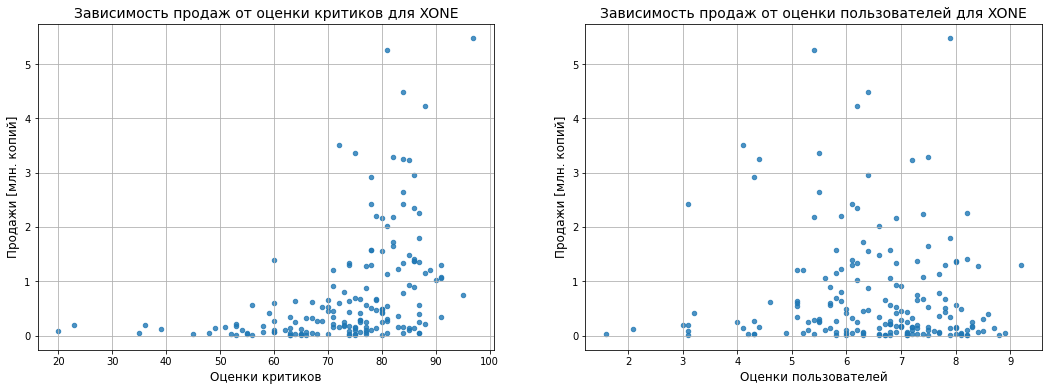

Коэффициент корреляции продаж с оценками критиков для XONE равен: 0.41699832800840175
Коэффициент корреляции продаж с оценками пользователей для XONE равен: -0.06892505328279412


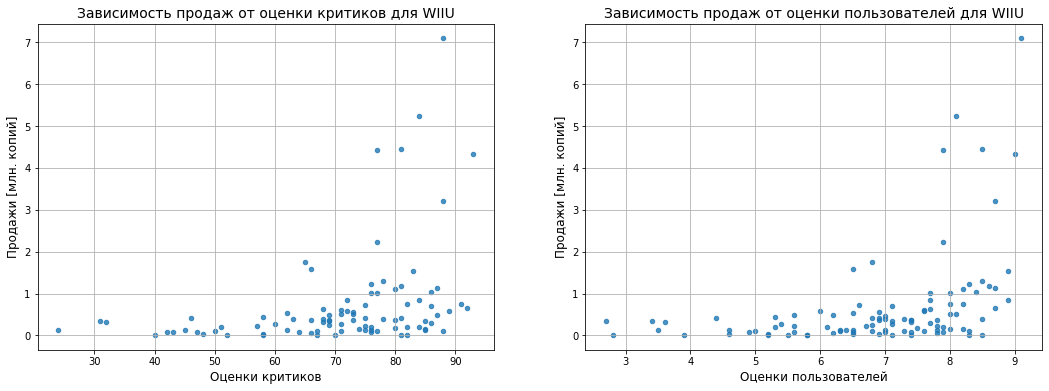

Коэффициент корреляции продаж с оценками критиков для WIIU равен: 0.3483797601201749
Коэффициент корреляции продаж с оценками пользователей для WIIU равен: 0.4002190202148617


In [19]:
# Вызовем функцию построения распределений

plot_sales_score(df_filtered, 'xone')

plot_sales_score(df_filtered, 'wiiu')

По Xbox One наблюдается схожее распределение. Можем сделать вывод, что зависимость слабая. Не каждая игра, хорошо оцененная критиками, приходится по душе игрокам и наоборот, коэффициенты корреляции помогают в этом убедиться. Оценки пользователей в Америке и Европе не имеют линейной зависимости с продажами, люди в данных регионах обращают гораздо большее внимание на оценки критиков. В Японии же люди одинаково полагаются на мнения критиков и мнение пользователей, но по прежнему коэффициенты корреляции принимают средние значения.

Далее рассмотрим жанровое распределение игр и их прибыльность в зависимости от принадлежности к тому или иному жанру. Изобразим столбчатую диаграмму количества проектов по жанру и диаграмму продаж по жанру, но будем смотреть продажи только за последние 5 лет, так как мода на определенные жанры сильно меняется в зависимости от времени:

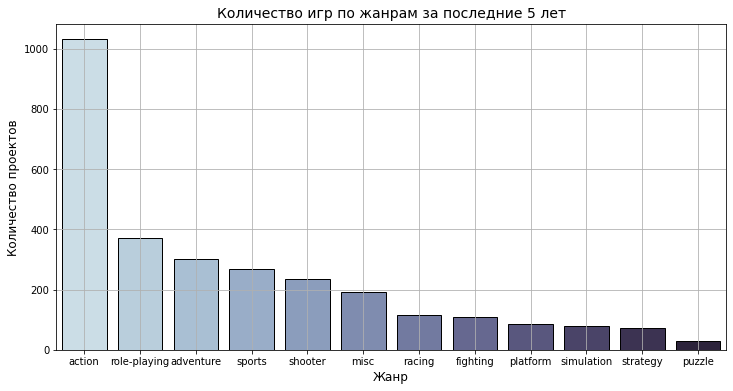

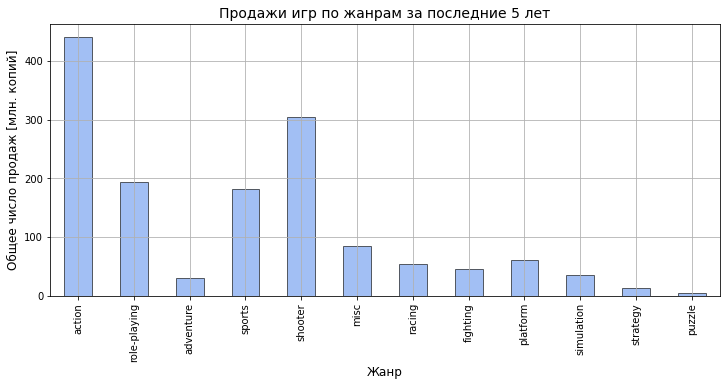

In [20]:
# Изобразим столбчатую диаграмму количества по жанрам

plt.figure(figsize=(12, 6))
sns.countplot(
    data=df_filtered,
    x='genre',
    palette='ch:s=.25,rot=-.25',
    order=df_filtered['genre'].value_counts().index,
    edgecolor='black'
)
plt.grid(True)
plt.title('Количество игр по жанрам за последние 5 лет', fontsize=14)
plt.xlabel('Жанр', fontsize=12)
plt.ylabel('Количество проектов', fontsize=12)
plt.show()

# Созадим сводную таблицу с количеством продаж и количеством игр в жанре

df_genre = df_filtered.groupby(by='genre').agg(
    {
        'eu_sales' : 'sum',
        'na_sales' : 'sum',
        'jp_sales' : 'sum',
        'world_sales' : 'sum',
        'name' : 'count'
    }
).sort_values('name', ascending=False)

# Изобразим столбчатую диаграмму продаж по жанрам

df_genre.plot(
    kind='bar',
    y='world_sales',
    edgecolor='black',
    color='cornflowerblue',
    alpha=0.6,
    figsize=(12, 5),
    grid=True,
    legend=False
)
plt.title('Продажи игр по жанрам за последние 5 лет', fontsize=14)
plt.xlabel('Жанр', fontsize=12)
plt.ylabel('Общее число продаж [млн. копий]', fontsize=12)
plt.show()

Бесспорными лидерами как по количеству игр, так и по количеству продаж являются игры в жанре *action* и *shooter*. Однако по данным графикам нельзя объективно судить о прибыльности тех или иных жанров. Следует изобразить еще одну диаграмму со средними продажами на каждый вышедший проект в данном жанре:

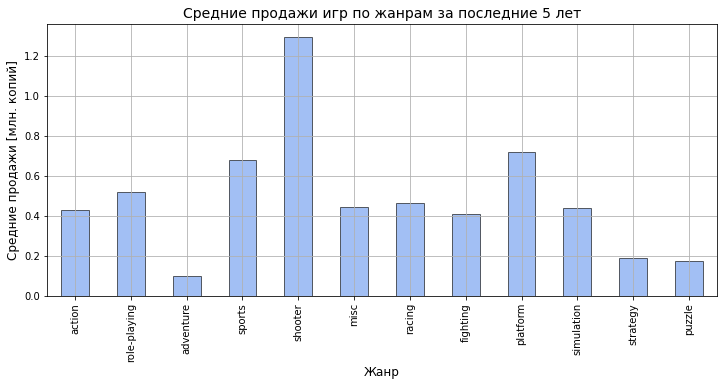

In [21]:
# Добавим новый столбец в сводную таблицу

df_genre['share_world_sales'] = df_genre['world_sales'] / df_genre['name']

# Изобразим столбчатую диаграмму

df_genre.plot(
    kind='bar',
    y='share_world_sales',
    edgecolor='black',
    color='cornflowerblue',
    alpha=0.6,
    figsize=(12, 5),
    grid=True,
    legend=False
)
plt.title('Средние продажи игр по жанрам за последние 5 лет', fontsize=14)
plt.xlabel('Жанр', fontsize=12)
plt.ylabel('Средние продажи [млн. копий]', fontsize=12)
plt.show()

Из данной таблицы можем заметить, что выделенный ранее жанр *action*, как самый популярный, не является в среднем самыми продаваемым. Выделим три самых продаваемых жанра:
* Shooter
* Platform
* Sports

Наихудший же показатель у жанра *adventure*. Такое жанровое распределение можно связать лишь с общей тенденцией на мультиплеерную направленность многих текущих проектов. Как првило в таких жанрах как *shooter, sports, racing, fighting* и даже иногда *RPG* подразумевают наличие в них мультиплеерного режима, который порой является основной причиной покупки игры. Примерами таких игр каждого из жанров могут быть `Battlefield`, `FIFA`, `Need For Speed`, `Mortal Combat` и `Baldur's Gate 2`.

<a id='users'></a>
## Портреты пользователей

Для выработки стратегии рекламных кампаний важно учитывать региональные предпочтения пользователей. Необходимо составить типовой портрет пользователей по трем представленным регионам:
* Северная Америка
* Европа
* Япония

Определим самые популярные платформы по каждому из регионов, будем судить о популярности по долям продаж на платформе.

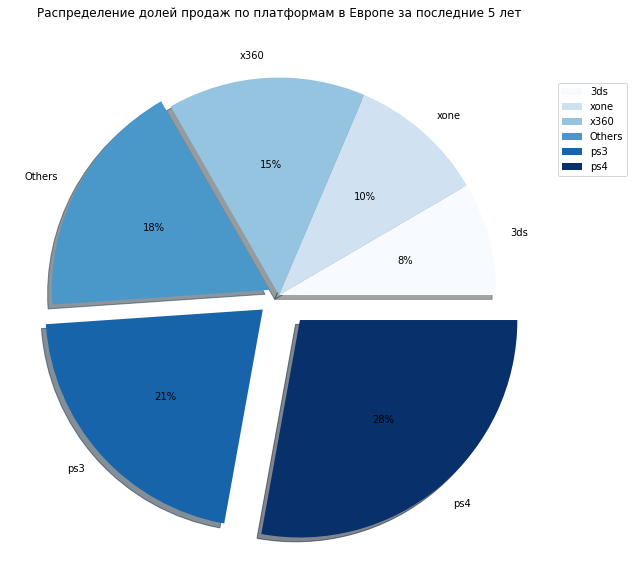

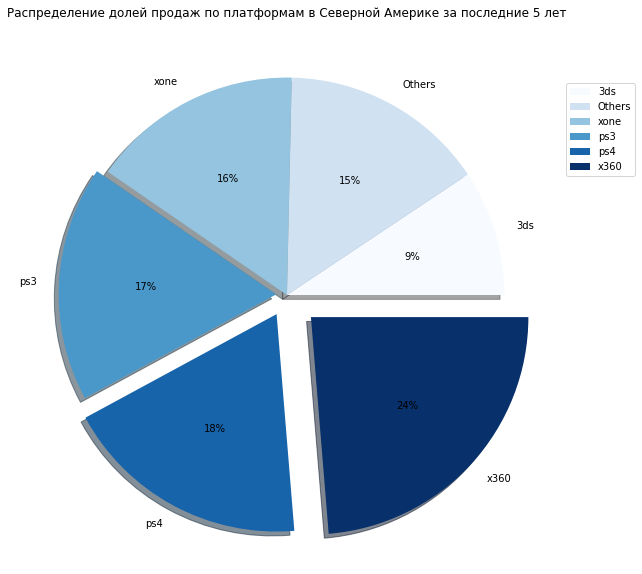

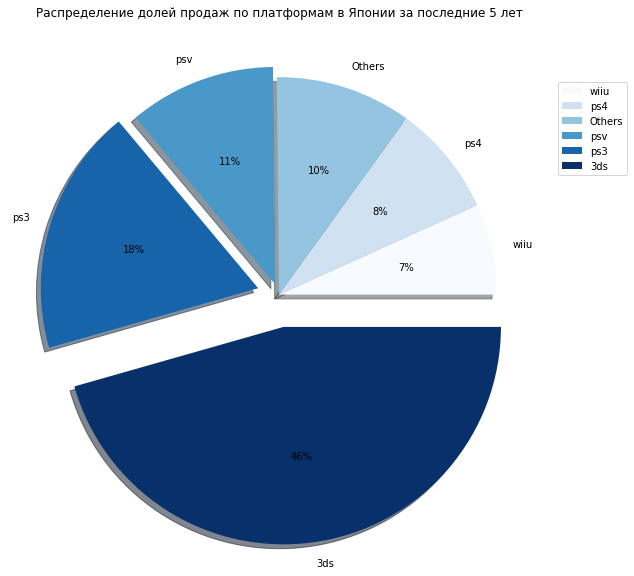

In [76]:
# Создадим функцию для построения круговой диаграммы

def category_platform(data, type_category, region, category_title, region_title):
    
    # Создадим сводную таблицу по платформам/жанрам с продажами в регионах

    df_pivot = data.pivot_table(index=type_category, values=region, aggfunc='sum')
    
    # Выделяем топ-5
    
    top5 = df_pivot.nlargest(5, region)[region]
    
    # Находим количество оставшихся продаж
    
    other = df_pivot[region].sum() - top5.sum()
    
    # Добавляем новый столбец в топы
    
    top5['Others'] = other
    
    # Построим круговую диаграмму по категориям
    
    top5.sort_values().plot(
        kind='pie',
        y=region,
        title=f'Распределение долей продаж по {category_title} в {region_title} за последние 5 лет',
        ylabel='',
        shadow=True,
        autopct='%1.0f%%',
        explode=(0, 0, 0, 0.05, 0.1, 0.15),
        colormap='Blues',
        normalize=True,
        figsize=(10, 10)
    )
    plt.legend(
        bbox_to_anchor = (1.15, 0.9),
        labels=top5.sort_values().index
    )
    plt.show()

category_platform(df_filtered, 'platform', 'eu_sales', 'платформам', 'Европе')

category_platform(df_filtered, 'platform', 'na_sales', 'платформам', 'Северной Америке')

category_platform(df_filtered, 'platform', 'jp_sales', 'платформам', 'Японии')

Пройдемся по каждому региону:
* на европейском рынке следует в первую очередь делать упор на PS4, так как продажи на данной платформе кратно опережают все другие. Также стоит обратить внимание на Xbox One, которы также показывает хорошие продажи. PS3 и Xbox 360 точно не дадут хороших продаж, потому что, как было выяснено ранее, сейчас набирают популярность платформы следующего поколения;
* ситуация на американском рынке схожа с европейским, однако платформы Xbox One и PS4 там почти одинаково популярны с небольшим опережением первого, остальные же платформы рассматривать не имеет смысла в виду их устаревания, доля их продаж не следующий год будет стремительно падать;
* интересен японский рынок со своей любовью к портативным платформам. Здесь крайней популярностью пользуется 3DS и, несмотря на спадающую тенденцию продаж, стоит ожидать хороших продаж от данной платформы в грядущем году. Также следует заметить высокие доли продаж у PSV и платформу PS4 (которая еще не успела набрать пиковые продажи). Остальные платформы находятся на "заре" своих продаж.

Разберемся, с жанровой принадлежностью в разных регионах. В отличие от платформ, мода на жанры игр меняется не так быстро, поэтому достаточно будет посмотреть на диаграмму продаж по жанрам в каждом регионе за актуальный период.

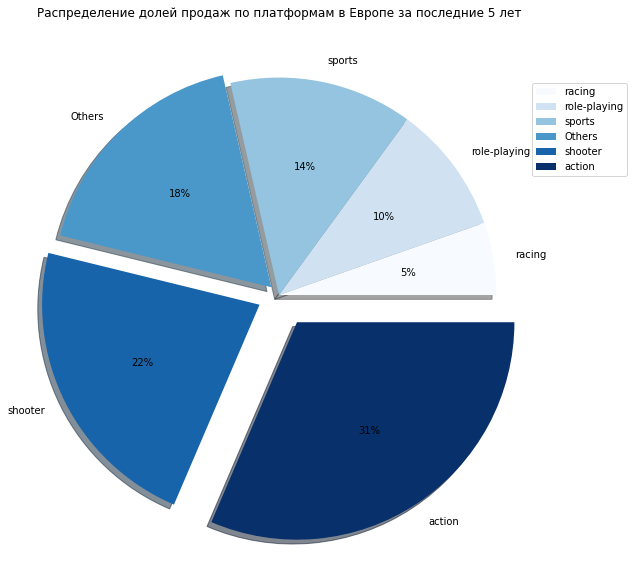

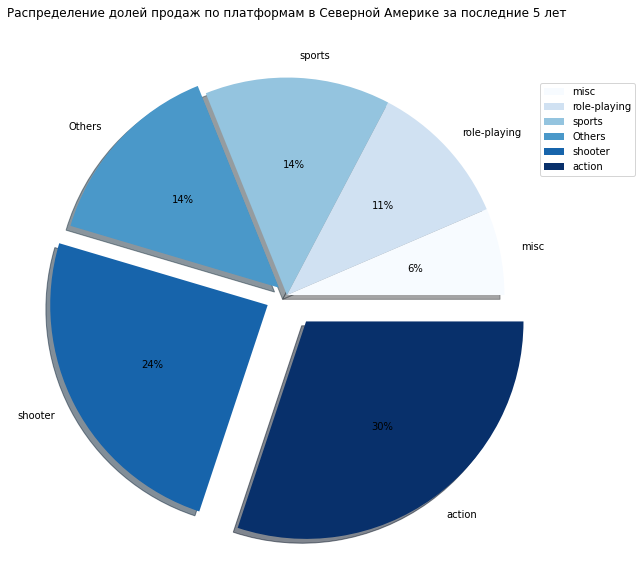

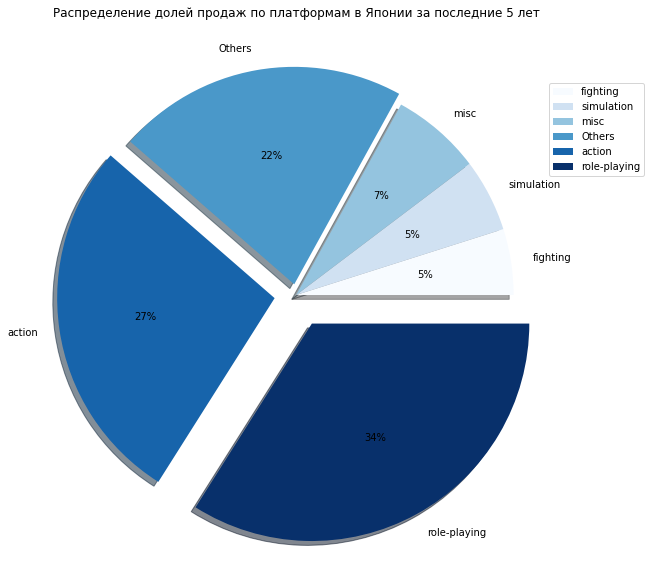

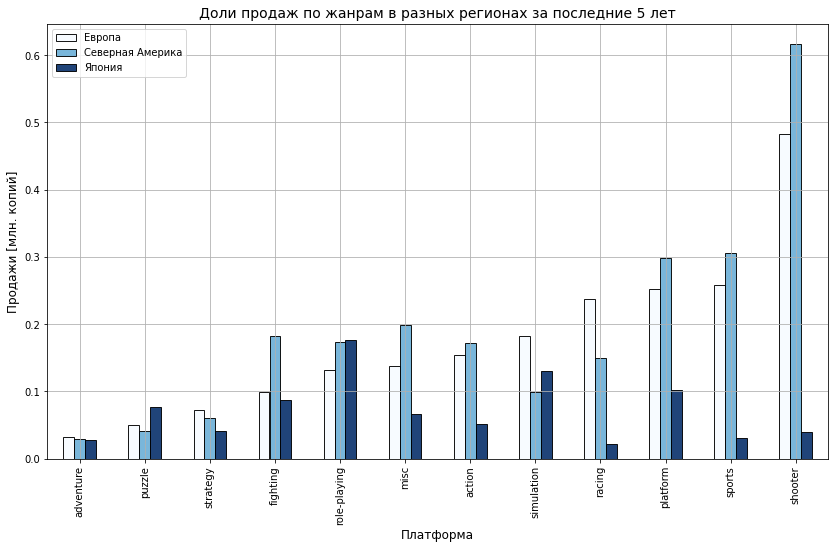

In [77]:
category_platform(df_filtered, 'genre', 'eu_sales', 'платформам', 'Европе')

category_platform(df_filtered, 'genre', 'na_sales', 'платформам', 'Северной Америке')

category_platform(df_filtered, 'genre', 'jp_sales', 'платформам', 'Японии')

# Добавим столбцы с долями продаж по жанрам в регионах

df_genre['share_eu_sales'] = df_genre['eu_sales'] / df_genre['name']

df_genre['share_na_sales'] = df_genre['na_sales'] / df_genre['name']

df_genre['share_jp_sales'] = df_genre['jp_sales'] / df_genre['name']

# Изобразим столбчатую диаграмму продаж

df_genre.reset_index().sort_values(by='share_eu_sales').plot(
    kind='bar',
    x='genre',
    y=['share_eu_sales', 'share_na_sales', 'share_jp_sales'],
    colormap='Blues',
    edgecolor='black',
    alpha=0.9,
    grid=True,
    figsize=(14, 8)
)
plt.title('Доли продаж по жанрам в разных регионах за последние 5 лет', fontsize=14)
plt.xlabel('Платформа', fontsize=12)
plt.ylabel('Продажи [млн. копий]', fontsize=12)
plt.legend(['Европа','Северная Америка','Япония'])
plt.show()

Можем составить рейтинг пяти самых продаваемых жанров в каждом регионе:
1. Место
    * В Европе - *Action*
    * В Северной Америке - *Action*
    * В Японии - *RPG*
2. Место
    * В Европе - *Shooter*
    * В Северной Америке - *Shooter*
    * В Японии - *Simulation*
3. Место
    * В Европе - *Sports*
    * В Северной Америке - *Sports*
    * В Японии - *Platform*
4. Место
    * В Европе - *RPG*
    * В Северной Америке - *RPG*
    * В Японии - *Fighting*
5. Место
    * В Европе - *Racing*
    * В Северной Америке - *Misc*
    * В Японии - *Pazzle*
    
Определим влияние возрастного ограничения игр на продажи:

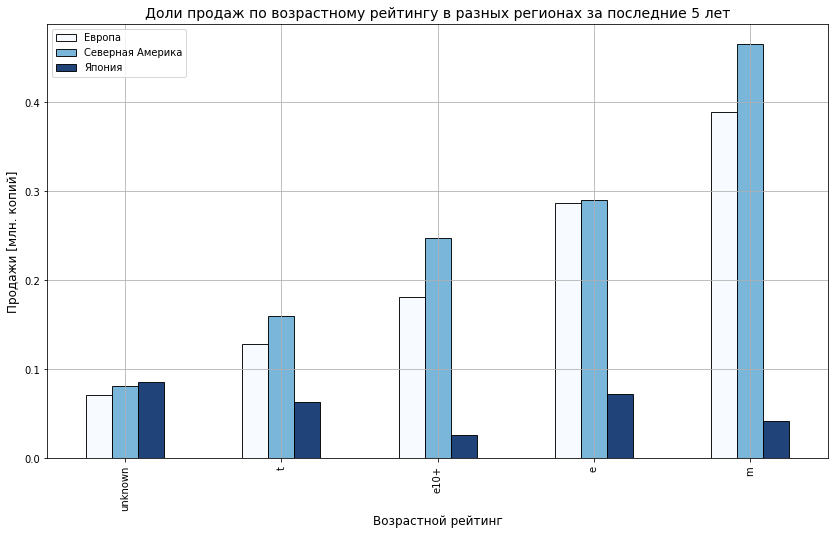

In [25]:
# Создадим сводную таблицу с распределением продаж в регионах по возрастному рейтингу за последние 5 лет

df_rating = df_filtered.groupby(by='rating').agg(
    {
        'eu_sales' : 'sum',
        'na_sales' : 'sum',
        'jp_sales' : 'sum',
        'name' : 'count'
    }
)

# Создадим нове столбцы с долями продаж

df_rating['share_eu_sales'] = df_rating['eu_sales'] / df_rating['name']

df_rating['share_na_sales'] = df_rating['na_sales'] / df_rating['name']

df_rating['share_jp_sales'] = df_rating['jp_sales'] / df_rating['name']

# Изобразим столбчатую диаграмму продаж

df_rating.reset_index().sort_values(by='share_eu_sales').plot(
    kind='bar',
    x='rating',
    y=['share_eu_sales', 'share_na_sales', 'share_jp_sales'],
    colormap='Blues',
    edgecolor='black',
    alpha=0.9,
    grid=True,
    figsize=(14, 8)
)
plt.title('Доли продаж по возрастному рейтингу в разных регионах за последние 5 лет', fontsize=14)
plt.xlabel('Возрастной рейтинг', fontsize=12)
plt.ylabel('Продажи [млн. копий]', fontsize=12)
plt.legend(['Европа','Северная Америка','Япония'])
plt.show()

Поясним, что значат возрастные рейтинги в системе ESRB:
* E (Everyone) - для всех возрастов;
* Е10+ (Everyone 10 and older) - для всех старше 10 лет;
* T (Teen) - подросткам старше 13 лет;
* M (Mature) - для взрослых старше 17 лет.

В Америке и Европе выделяются продажи среди игр для взрослых и игр для всех, остальные - менее продаваемы. В Японии все не так однозначно, т.к. большую часть данных занимают неизвестные значения, по оставшимся вариантам серьезных различий не наблюдается. Вероятно, как и было сказано ранее, на многие игры в Японии ESRB не выставляет свой рейтинг, так как их деятельность ограничена Канадой, США и Мексикой.

Подитожив, можем сформировать портреты пользователей. 

Американец предпочтет игру для взрослых в жанре *Shooter* или *Sports*, вышедшую на платформе *Xbox One* или *PS4*.

Европеец имеет схожий портрет за малым исключением, что большее предпочтение отдается платформе *PS4*.

Японец вероятнее всего захочет приобрести игру с любым возрастным ограничением в жанре *RPG* или *Simulation* на платформах *PS4*, *3DS* или *PSV*.

<a id='hypotheses'></a>
## Проверка гипотез

<a id='user_score'></a>
### Гипотеза о равенстве средних пользовательских оценок для PC и Xbox One

Проверим равны ли в среднем оценки пользователей по двум платформам одной компании Microsoft. Такие тесты с проверкой о равенстве средних проводятся с помощью t-тестов. Данные выборки можем считать независимыми, так как оценки относятся к разным платформам. Сформулируем нулевую и альтернативную двухстороннюю гипотезы:

$H_0:$ средние оценки пользователей для игр на PC и Xbox One одинаковые;  
$H_1:$ средние оценки пользователей для игр на PC и Xbox One разные.

<div class="alert alert-block alert-success">
<b>✅Комментарий ревьюера:</b> Здорово, что формулируешь гипотезы перед проверкой </div>

<div class="alert alert-block alert-danger">
<b>❌Комментарий ревьюера:</b> 
    
Проверку гипотез нужно проводить также по данным из актуального периода.</div>

<div class="alert alert-block alert-success">
<b>✅Комментарий ревьюера 2:</b> Отлично, исправлено!👍  </div>

<div class="alert alert-block alert-info">
<b>🔄Комментарий студента:</b> 
Сделано✔
</div>

In [26]:
# Зададим уровень статистической значимости
alpha_platform = 0.05

# Найдем p-value. equal_var=False, т.к. выборки слишком отличаются по размеру,
# не можем с уверенностью говорить о равенстве дисперсий

results_platform = st.ttest_ind(
    df_filtered.query('user_score > 0 and platform == "pc"')['user_score'],
    df_filtered.query('user_score > 0 and platform == "xone"')['user_score'],
    equal_var=False,
    alternative='two-sided'
)

print('Средние оценки на PC:', df.query('user_score > 0 and platform == "pc"')['user_score'].mean())

print('Средние оценки на Xbox One:', df.query('user_score > 0 and platform == "xone"')['user_score'].mean())

print('Значение p-value:', results_platform.pvalue)

# Проверка гипотезы
if results_platform.pvalue < alpha_platform:
    print('Отвергаем нулевую гипотезу в пользу альтернативной')
    
else:
    print('Не отвергаем нулевую гипотезу')

Средние оценки на PC: 7.065960264900661
Средние оценки на Xbox One: 6.521428571428572
Значение p-value: 0.5489537965134912
Не отвергаем нулевую гипотезу


Отвергнуть нулевую гипотезу не вышло, не можем утверждать, что оценки на PC и Xbox One разные.

<a id='user_genre'></a>
### Гипотеза о неравенстве средних пользовательских оценок для жанров *sports* и *action*

Проверим, что оценки пользователей по жанрам *sports* и *action* не равны. Как и в прошлом случае будем пользоваться T-тестом для двух независимых выборок, однако формулировать нулевую гипотезу будем исходя из равенства средних оценок, а альтернативную гипотезу сформулируем двусторонней:

$H_0:$ средние оценки пользователей для игр в жанре *sports* и *action* одинаковые;  
$H_1:$ средние оценки пользователей для игр в жанре *sports* и *action* разные.

In [49]:
# Зададим уровень статистической значимости
alpha_genre = 0.05

results_genre = st.ttest_ind(
    df_filtered.query('user_score > 0 and genre == "action"')['user_score'],
    df_filtered.query('user_score > 0 and genre == "sports"')['user_score'],
    equal_var=False
)

print('Средние оценки в жанре Action:', df.query('user_score > 0 and genre == "action"')['user_score'].mean())

print('Средние оценки в жанре Sports:', df.query('user_score > 0 and genre == "sports"')['user_score'].mean())

print('Значение p-value:', results_genre.pvalue)

# Проверка гипотезы
if results_genre.pvalue < alpha_genre:
    print('Отвергаем нулевую гипотезу в пользу альтернативной')
    
else:
    print('Не отвергаем нулевую гипотезу')

Средние оценки в жанре Action: 7.058129175946549
Средние оценки в жанре Sports: 6.9527777777777775
Значение p-value: 5.989458066467418e-20
Отвергаем нулевую гипотезу в пользу альтернативной


Нулевая гипотеза была отвергнута, можем сказать, что средние пользовательские оценки на игры в жанре *Action* и *Sports* разные.

<a id='conclutions'></a>
## Выводы

Было проведено исследование продаж интернет-магазина «Стримчик».

Мы изучили общую информацию о данных, оценили их полноту и дали комментарии. Провели предобработку данных:

* исправлены названия столбцов под соответствующий стиль;
* обработаны пропуски;
* изменены типы данных на корректные;
* произведен поиск и обработка дубликатов.

Произвели исследовательский анализ:

* изучили, как менялись продажи на разных платформах с течением времени, выявили характерный период "жизни" платформы, отобрали наиболее продаваемые;
* определили актуальный период, в который реализуются максимальные продажи на платформе. Выявили потенциально прибыльные платформы в соответствующий период;
* оценили наиболее прибыльные жанры в текущий период времени.

Был составлен портрет пользователя в зависимости от принадлежности к тому или иному региону, который поможет выработать стратегию продаж и рекламы. Сформулировали и проверили статистические гипотезы по результатам которых можем сказать:

* нельзя с уверенностью утверждать, что средние пользовательские оценки на PC отличаются от Xbox One;
* можем сказать, что средние пользовательские оценки на игры в жанре *Action* и *Sports* разные.

**Рекомендации заказчику**

При выработке стратегии продаж, следует использовать разный подход в зависимости от региона продажи. По трем рассмотренным регионам сформулированы следующие рекомендации.

*Северная Америка*

Средний пользователь нацелен на покупки игр, вышедших на платформах PS4 и Xbox One. Игры на данных платформах почти в равной степени пользуются высоким спросом с небольши уклоном в сторону второго, продумывать рекламу таких игр следует в первую очередь. Также прибыльной платформой является Wii U, за ней наблюдаются высокие доли продаж и меньшим количеством игр чем у PS4 и Xbox one. Реклама таких игр с высокой долей вероятности принесет хорошую прибыль. Оставшиеся платформы изжили себя на них не следует делать основную ставку. 

Американец отдает свое предпочтение в сторону жанров *Shooter*, *Sports* и *Platform* преимущественно с возрастным ограничением M (Mature) - для взрослых.

*Европа*

Здесь средний пользователь очень схож с американцем. Отдает большее предпочтение в сторону PS4 в сравнении с Xbox One. Предпочтения в жанрах практически идентичные с точно таким же возрастным рейтингом игр , как у американца.

*Япония*

Средний японец захочет купить игру для портативной приставки 3DS и Wii U. Не стоит забывать об очень перспективной и родной для страны PS4, она еще не успела набрать пиковые продажи в стране. Игры на данных платформах продаются очень хорошо. Популярный на западе Xbox One здесь показывает абсолютно провальные продажи. Также потенциально возможно, что в грядущем году прибыльными окажутся игры и для PSV, но их прибыльность будет кратно ниже чем у PS4 и 3DS.

Самый популярный и продаваемый жанр здесь *RPG*, после него следуеет обратить внимание на *Simulation* и в последнюю очередь *Platform*, что примечательно, возрастные ограничения не влияют на продажи в Японии.